# 🚗 Number Plate Detection with YOLO: From XML Annotations to a Ready-to-Train Dataset

This notebook demonstrates the end-to-end preparation of a number plate object detection dataset.  
We source annotations from two open Kaggle datasets, perform exploratory data analysis (EDA), convert annotations to YOLO format, and build a clean YOLO-compatible folder structure ready for training.


## 1. Importing Datasets from KaggleHub

We begin by downloading two datasets using `kagglehub`:

- `aslanahmedov/number-plate-detection`
- `andrewmvd/car-plate-detection`

Both datasets contain XML annotations in Pascal VOC format, which we’ll merge and convert later.


In [1]:
import kagglehub

# Download latest version
path1 = kagglehub.dataset_download("aslanahmedov/number-plate-detection")

print("Path to dataset files:", path1)

# Download latest version
path2 = kagglehub.dataset_download("andrewmvd/car-plate-detection")

print("Path to dataset files:", path2)

Path to dataset files: /kaggle/input/number-plate-detection
Path to dataset files: /kaggle/input/car-plate-detection


## 2. Organizing XML and Image Files

We collect all `.xml` annotation files into a single folder:


In [2]:
import os
import shutil
from glob import glob

# Input folders
src1 = '/kaggle/input/car-plate-detection/annotations'
src2 = '/kaggle/input/number-plate-detection/images'

# Output folder
target_folder = '/kaggle/working/merged_xml'
os.makedirs(target_folder, exist_ok=True)

# Collect all .xml files from both sources
xml_files_1 = glob(os.path.join(src1, '*.xml'))
xml_files_2 = glob(os.path.join(src2, '*.xml'))

all_xml_files = xml_files_1 + xml_files_2
print(f"[INFO] Found {len(all_xml_files)} .xml files in total.")

# Copy and handle name collisions
for xml_path in all_xml_files:
    filename = os.path.basename(xml_path)
    target_path = os.path.join(target_folder, filename)
    
    # If file with same name exists, append a number
    if os.path.exists(target_path):
        base, ext = os.path.splitext(filename)
        i = 1
        while os.path.exists(os.path.join(target_folder, f"{base}_{i}{ext}")):
            i += 1
        target_path = os.path.join(target_folder, f"{base}_{i}{ext}")
    
    shutil.copy(xml_path, target_path)

print(f"[SUCCESS] Copied all XML files to: {target_folder}")


[INFO] Found 658 .xml files in total.
[SUCCESS] Copied all XML files to: /kaggle/working/merged_xml


We also collect all image files (JPEG/PNG):


In [3]:
import os
import shutil
from glob import glob

# Input folders
src1 = '/kaggle/input/car-plate-detection/images'
src2 = '/kaggle/input/number-plate-detection/images'

# Output folder
target_folder = '/kaggle/working/images'
os.makedirs(target_folder, exist_ok=True)

# Acceptable image extensions
img_extensions = ['*.jpg', '*.jpeg', '*.png']

# Gather all image files from both folders
all_images = []
for ext in img_extensions:
    all_images.extend(glob(os.path.join(src1, ext)))
    all_images.extend(glob(os.path.join(src2, ext)))

print(f"[INFO] Found {len(all_images)} image files.")

# Copy and handle filename collisions
for img_path in all_images:
    filename = os.path.basename(img_path)
    target_path = os.path.join(target_folder, filename)
    
    # Handle duplicates
    if os.path.exists(target_path):
        base, ext = os.path.splitext(filename)
        i = 1
        while os.path.exists(os.path.join(target_folder, f"{base}_{i}{ext}")):
            i += 1
        target_path = os.path.join(target_folder, f"{base}_{i}{ext}")
    
    shutil.copy(img_path, target_path)

print(f"[SUCCESS] Copied all image files to: {target_folder}")


[INFO] Found 661 image files.
[SUCCESS] Copied all image files to: /kaggle/working/images


## 3. Exploratory Data Analysis (EDA) on Image Data

We inspect the image dimensions, file types, and aspect ratios:

- **Image height & width distribution**
- **Aspect ratio histogram**
- **File size distribution**
- **File type breakdown**

These help validate consistency across image sources.


In [4]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# Set style
sns.set(style='whitegrid')

# Folder with images
img_dir = '/kaggle/working/images'
img_paths = glob(os.path.join(img_dir, '*'))

print(f"Found {len(img_paths)} image files.")

# Collect metadata
img_data = []

for path in img_paths:
    try:
        img = cv2.imread(path)
        if img is None:
            continue
        h, w = img.shape[:2]
        size_kb = os.path.getsize(path) / 1024
        ext = os.path.splitext(path)[1].lower()
        img_data.append({
            'filename': os.path.basename(path),
            'width': w,
            'height': h,
            'aspect_ratio': round(w / h, 2),
            'file_size_kb': round(size_kb, 2),
            'ext': ext
        })
    except Exception as e:
        print(f"Failed reading {path}: {e}")

df = pd.DataFrame(img_data)
df.head()


Found 661 image files.


,filename,width,height,aspect_ratio,file_size_kb,ext
0,Cars99.png,375,500,0.75,200.57,.png
1,Cars269.png,400,300,1.33,695.49,.png
2,Cars217.png,400,240,1.67,505.54,.png
3,N167.jpeg,960,720,1.33,116.98,.jpeg
4,Cars190.png,400,300,1.33,701.68,.png


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


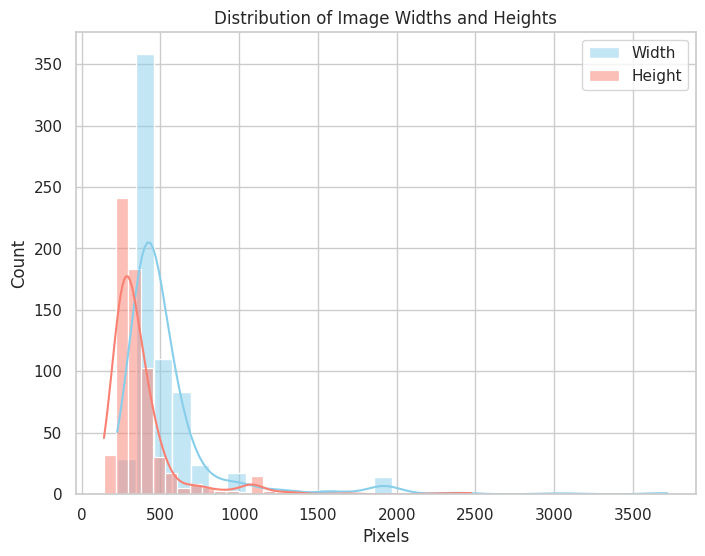

In [5]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='width', bins=30, color='skyblue', label='Width', kde=True)
sns.histplot(data=df, x='height', bins=30, color='salmon', label='Height', kde=True)
plt.legend()
plt.title("Distribution of Image Widths and Heights")
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


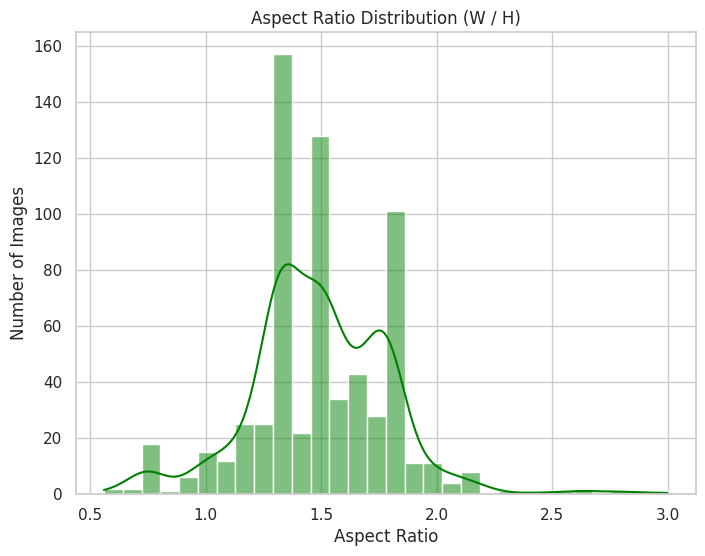

In [6]:
plt.figure(figsize=(8, 6))
sns.histplot(df['aspect_ratio'], bins=30, color='green', kde=True)
plt.title("Aspect Ratio Distribution (W / H)")
plt.xlabel("Aspect Ratio")
plt.ylabel("Number of Images")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


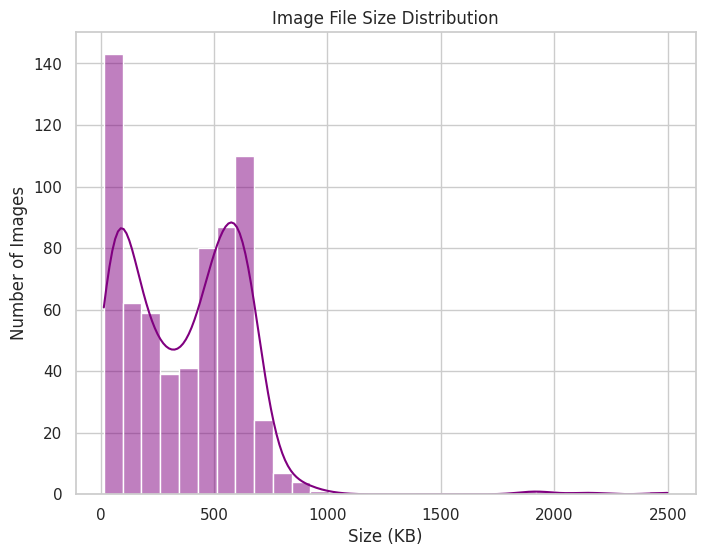

In [7]:
plt.figure(figsize=(8, 6))
sns.histplot(df['file_size_kb'], bins=30, color='purple', kde=True)
plt.title("Image File Size Distribution")
plt.xlabel("Size (KB)")
plt.ylabel("Number of Images")
plt.show()


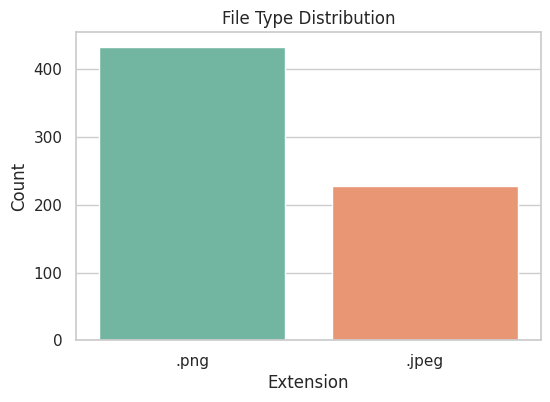

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='ext', palette='Set2')
plt.title("File Type Distribution")
plt.xlabel("Extension")
plt.ylabel("Count")
plt.show()


## 4. EDA on Annotation (XML) Data

We parse the Pascal VOC XMLs to extract class labels and bounding boxes.

Key insights include:

- **Class frequency**
- **Distribution of bounding box areas**
- **Relative bbox size (as % of image area)**
- **Number of bounding boxes per image**


In [9]:
import xml.etree.ElementTree as ET
import pandas as pd
import os
from glob import glob

xml_dir = '/kaggle/working/merged_xml'
xml_files = glob(os.path.join(xml_dir, '*.xml'))

print(f"[INFO] Found {len(xml_files)} XML files")

# Collect all annotation data into a list of dicts
annotations = []

for xml_file in xml_files:
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()

        img_filename = root.find('filename').text
        width = int(root.find('size/width').text)
        height = int(root.find('size/height').text)

        for obj in root.findall('object'):
            cls_name = obj.find('name').text.strip().lower()
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            box_width = xmax - xmin
            box_height = ymax - ymin
            area = box_width * box_height
            rel_area = area / (width * height)

            annotations.append({
                'image': img_filename,
                'class': cls_name,
                'img_width': width,
                'img_height': height,
                'xmin': xmin,
                'ymin': ymin,
                'xmax': xmax,
                'ymax': ymax,
                'box_width': box_width,
                'box_height': box_height,
                'bbox_area': area,
                'rel_area': rel_area
            })
    except Exception as e:
        print(f"[WARN] Failed on {xml_file}: {e}")


[INFO] Found 658 XML files


In [10]:
df_ann = pd.DataFrame(annotations)
print(f"[INFO] Parsed {len(df_ann)} annotations across {df_ann['image'].nunique()} images")
df_ann.head()


[INFO] Parsed 696 annotations across 658 images


,image,class,img_width,img_height,xmin,ymin,xmax,ymax,box_width,box_height,bbox_area,rel_area
0,N192.jpeg,number_plate,1250,703,543,390,769,461,226,71,16046,0.018260
1,N58.jpeg,number_plate,640,435,221,190,430,231,209,41,8569,0.030779
2,N32.jpeg,number_plate,600,378,360,171,500,206,140,35,4900,0.021605
3,Cars129.png,licence,530,398,204,213,282,267,78,54,4212,0.019968
4,Cars143.png,licence,400,267,93,196,130,207,37,11,407,0.003811


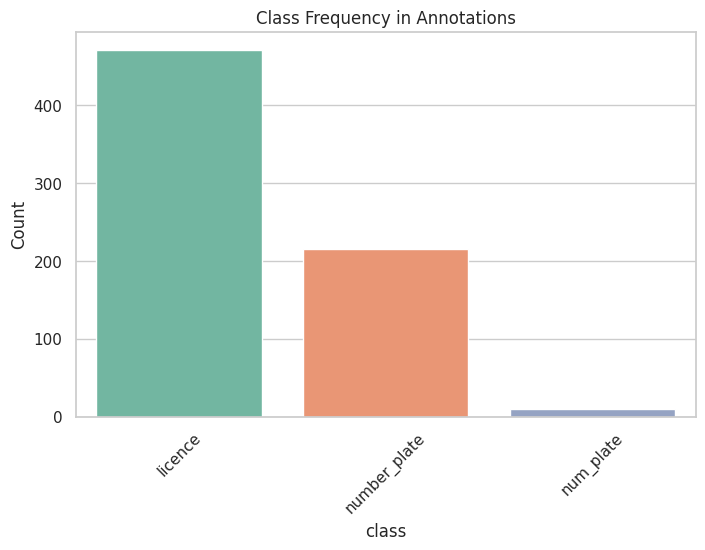

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=df_ann, x='class', order=df_ann['class'].value_counts().index, palette='Set2')
plt.title("Class Frequency in Annotations")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


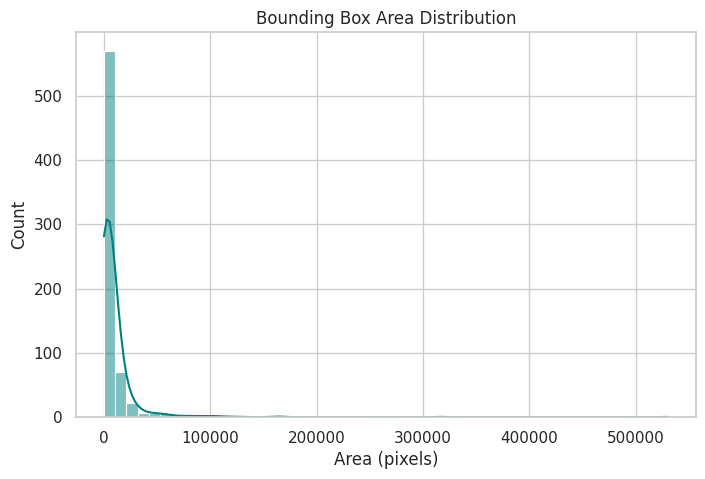

In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(df_ann['bbox_area'], bins=50, color='teal', kde=True)
plt.title("Bounding Box Area Distribution")
plt.xlabel("Area (pixels)")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


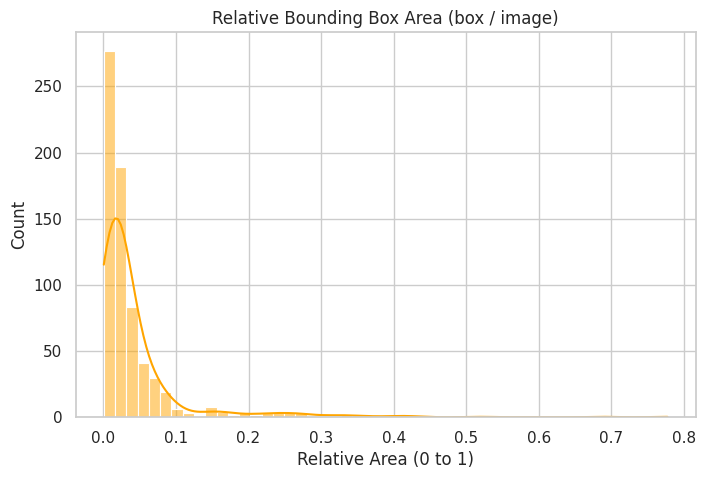

In [13]:
plt.figure(figsize=(8, 5))
sns.histplot(df_ann['rel_area'], bins=50, color='orange', kde=True)
plt.title("Relative Bounding Box Area (box / image)")
plt.xlabel("Relative Area (0 to 1)")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


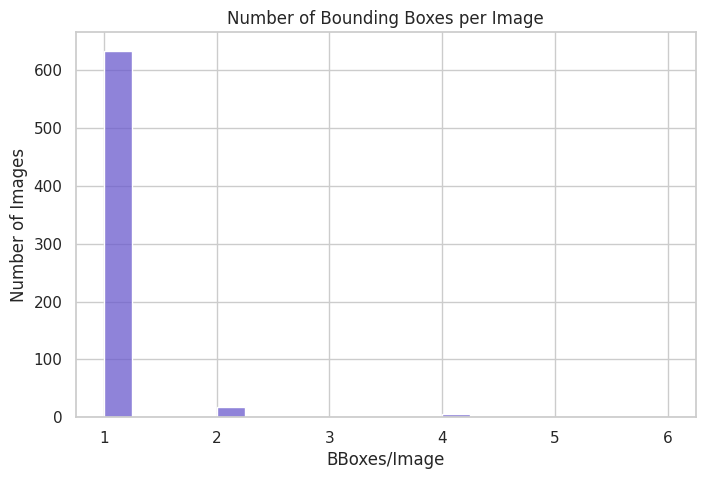

In [14]:
bbox_per_img = df_ann.groupby('image').size()

plt.figure(figsize=(8, 5))
sns.histplot(bbox_per_img, bins=20, color='slateblue', kde=False)
plt.title("Number of Bounding Boxes per Image")
plt.xlabel("BBoxes/Image")
plt.ylabel("Number of Images")
plt.show()


## 5. Converting Annotations to YOLO Format

We convert the Pascal VOC XML labels into YOLO `.txt` format.

Each `.txt` file corresponds to one image and contains:

`<class_id>  <x_center>  <y_center>  <width>  <height>`

In [15]:
import os
import xml.etree.ElementTree as ET

xml_folder = '/kaggle/working/merged_xml'
yolo_folder = '/kaggle/working/yolo_labels'
os.makedirs(yolo_folder, exist_ok=True)

def convert_bbox_to_yolo(xmin, ymin, xmax, ymax, img_width, img_height):
    x_center = (xmin + xmax) / 2.0 / img_width
    y_center = (ymin + ymax) / 2.0 / img_height
    width = (xmax - xmin) / img_width
    height = (ymax - ymin) / img_height
    return x_center, y_center, width, height

converted = 0

for xml_file in os.listdir(xml_folder):
    if not xml_file.endswith('.xml'):
        continue

    path = os.path.join(xml_folder, xml_file)
    try:
        tree = ET.parse(path)
        root = tree.getroot()

        size = root.find('size')
        img_w = int(size.find('width').text)
        img_h = int(size.find('height').text)

        lines = []
        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            xmin = int(float(bbox.find('xmin').text))
            ymin = int(float(bbox.find('ymin').text))
            xmax = int(float(bbox.find('xmax').text))
            ymax = int(float(bbox.find('ymax').text))

            x, y, w, h = convert_bbox_to_yolo(xmin, ymin, xmax, ymax, img_w, img_h)
            lines.append(f"0 {x:.6f} {y:.6f} {w:.6f} {h:.6f}")

        if lines:
            out_name = os.path.splitext(xml_file)[0] + '.txt'
            out_path = os.path.join(yolo_folder, out_name)
            with open(out_path, 'w') as f:
                f.write('\n'.join(lines))
            converted += 1
    except Exception as e:
        print(f"[ERROR] {xml_file}: {e}")
        continue

print(f"[SUCCESS] Converted {converted} XMLs into YOLO .txt labels.")


[SUCCESS] Converted 658 XMLs into YOLO .txt labels.


In [16]:
import os
import cv2
import matplotlib.pyplot as plt

xml_dir = '/kaggle/working/merged_xml'
img_dir = '/kaggle/working/images'
label_dir = '/kaggle/working/yolo_labels'

def verify_format(line):
    parts = line.strip().split()
    if len(parts) != 5:
        return False
    try:
        cls, x, y, w, h = map(float, parts)
        return 0 <= x <= 1 and 0 <= y <= 1 and 0 <= w <= 1 and 0 <= h <= 1
    except:
        return False

invalid_files = []
empty_files = []
total_labels = 0

for fname in os.listdir(label_dir):
    if not fname.endswith('.txt'):
        continue
    path = os.path.join(label_dir, fname)
    with open(path, 'r') as f:
        lines = f.readlines()
    
    if not lines:
        empty_files.append(fname)
        continue

    for line in lines:
        if not verify_format(line):
            invalid_files.append(fname)
            break
    total_labels += len(lines)

print(f"✅ Total YOLO labels: {total_labels}")
print(f"⚠️ Empty label files: {len(empty_files)} → {empty_files[:5]}")
print(f"❌ Invalid format files: {len(invalid_files)} → {invalid_files[:5]}")


✅ Total YOLO labels: 696
⚠️ Empty label files: 0 → []
❌ Invalid format files: 0 → []


In [17]:
import os

label_dir = '/kaggle/working/yolo_labels'

def is_valid_yolo_line(line):
    parts = line.strip().split()
    if len(parts) != 5:
        return False, "Wrong number of values"
    try:
        cls = int(parts[0])
        if cls < 0:
            return False, "Negative class index"
        coords = list(map(float, parts[1:]))
        if not all(0 <= c <= 1 for c in coords):
            return False, "Coordinates out of bounds (not in 0-1)"
    except ValueError:
        return False, "Non-numeric value found"
    return True, ""

def validate_yolo_labels(label_dir):
    all_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
    bad_files = []
    total_lines = 0
    bad_lines = 0

    for fname in all_files:
        path = os.path.join(label_dir, fname)
        with open(path, 'r') as f:
            lines = f.readlines()
        for idx, line in enumerate(lines):
            total_lines += 1
            valid, reason = is_valid_yolo_line(line)
            if not valid:
                bad_files.append({
                    'file': fname,
                    'line': idx + 1,
                    'content': line.strip(),
                    'reason': reason
                })
                bad_lines += 1

    print(f"✅ Checked {len(all_files)} files, {total_lines} lines")
    if bad_lines == 0:
        print("🎉 All label lines are valid!")
    else:
        print(f"❌ Found {bad_lines} bad lines in {len(set(f['file'] for f in bad_files))} files.")
        print("\nTop 5 issues:")
        for e in bad_files[:5]:
            print(f"[{e['file']} line {e['line']}]: {e['content']} → {e['reason']}")

    return bad_files

# Run this
bad = validate_yolo_labels('/kaggle/working/yolo_labels')


✅ Checked 658 files, 696 lines
🎉 All label lines are valid!


## 6. Preparing the YOLO Dataset Structure

We split the data 80/20 into train/val sets and organize it into a YOLO-compatible format:
```
YOLO_dataset/
├── images/
│   ├── train/
│   └── val/
├── labels/
│   ├── train/
│   └── val/
└── data.yaml
```

> ✅ 528 training images <br>
> ✅ 133 validation images <br>
> 📦 Dataset zipped and saved as /kaggle/working/YOLO_dataset.zip <br>


You can now train this using YOLOv8 with the following command:

`!yolo task=detect mode=train model=yolov8n.pt data=/kaggle/working/YOLO_dataset/data.yaml epochs=50 imgsz=640`

In [18]:
import os
import shutil
import random

# Input folders
IMG_DIR = '/kaggle/working/images'
LBL_DIR = '/kaggle/working/yolo_labels'

# Output root folder
ROOT = '/kaggle/working/YOLO_dataset'
OUT_IMG_DIR = os.path.join(ROOT, 'images')
OUT_LBL_DIR = os.path.join(ROOT, 'labels')

# Create folders
for split in ['train', 'val']:
    os.makedirs(os.path.join(OUT_IMG_DIR, split), exist_ok=True)
    os.makedirs(os.path.join(OUT_LBL_DIR, split), exist_ok=True)

# Split images
all_images = [f for f in os.listdir(IMG_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random.seed(42)
random.shuffle(all_images)

split_idx = int(0.8 * len(all_images))
train_imgs = all_images[:split_idx]
val_imgs = all_images[split_idx:]

def move_files(img_list, split):
    for img_name in img_list:
        name_no_ext = os.path.splitext(img_name)[0]
        label_name = f"{name_no_ext}.txt"

        src_img = os.path.join(IMG_DIR, img_name)
        src_lbl = os.path.join(LBL_DIR, label_name)

        dst_img = os.path.join(OUT_IMG_DIR, split, img_name)
        dst_lbl = os.path.join(OUT_LBL_DIR, split, label_name)

        if os.path.exists(src_lbl):
            shutil.copy2(src_img, dst_img)
            shutil.copy2(src_lbl, dst_lbl)

move_files(train_imgs, "train")
move_files(val_imgs, "val")

# Create data.yaml
yaml_path = os.path.join(ROOT, "data.yaml")
yaml_content = f"""
train: {os.path.join(ROOT, 'images/train')}
val: {os.path.join(ROOT, 'images/val')}

nc: 1
names: ['number_plate']
"""

with open(yaml_path, "w") as f:
    f.write(yaml_content.strip())

print(f"✅ YOLO dataset prepared at: {ROOT}")
print(f"📸 Train images: {len(train_imgs)} | 🧪 Val images: {len(val_imgs)}")


✅ YOLO dataset prepared at: /kaggle/working/YOLO_dataset
📸 Train images: 528 | 🧪 Val images: 133


In [19]:
import shutil

# Path to your dataset
folder_path = "/kaggle/working/YOLO_dataset"
zip_path = "/kaggle/working/YOLO_dataset.zip"

# Create ZIP
shutil.make_archive(base_name=zip_path.replace(".zip", ""), format='zip', root_dir=folder_path)

print(f"✅ Zipped successfully: {zip_path}")


✅ Zipped successfully: /kaggle/working/YOLO_dataset.zip
